<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W4/ungraded_lab/C2_W4_Lab_1_multi_class_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Multi-class Classifier

In this lab, you will look at how to build a model to distinguish between more than two classes. The code will be similar to the ones you've been using before with a few key changes in the model and in the training parameters. Let's dive in!


**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

## Download and Prepare the Dataset

You will be using the [Rock-Paper-Scissors dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors), a gallery of hands images in Rock, Paper, and Scissors poses.

In [1]:
# Download the train set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
    
# Download the test set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip

--2024-04-30 19:57:07--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.185.219, 142.250.184.251, 142.250.185.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.185.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M  10.3MB/s    in 19s     

2024-04-30 19:57:27 (9.87 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2024-04-30 19:57:27--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.185.219, 142.250.184.251, 142.250.185.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.185.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps

In [2]:
import zipfile

# Extract the archive
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-train')
zip_ref.close()

local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-test')
zip_ref.close()

As usual, you will assign the directory names into variables and look at the filenames as a sanity check.

In [3]:
import os

base_dir = 'tmp/rps-train/rps'

rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock04-105.png', 'rock04-101.png', 'rock02-087.png', 'rock07-k03-079.png', 'rock07-k03-111.png', 'rock01-106.png', 'rock05ck01-028.png', 'rock03-043.png', 'rock02-092.png', 'rock04-085.png']
['paper07-036.png', 'paper07-011.png', 'paper02-069.png', 'paper03-078.png', 'paper06-028.png', 'paper04-034.png', 'paper07-004.png', 'paper01-022.png', 'paper03-000.png', 'paper07-110.png']
['testscissors03-055.png', 'testscissors03-118.png', 'scissors01-092.png', 'testscissors03-073.png', 'testscissors03-022.png', 'scissors04-039.png', 'testscissors02-084.png', 'scissors02-070.png', 'scissors03-048.png', 'testscissors01-053.png']


You can also inspect some of the images to see the variety in your model inputs.

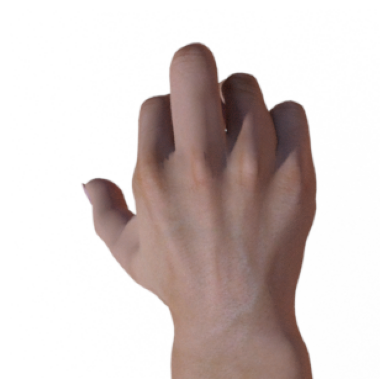

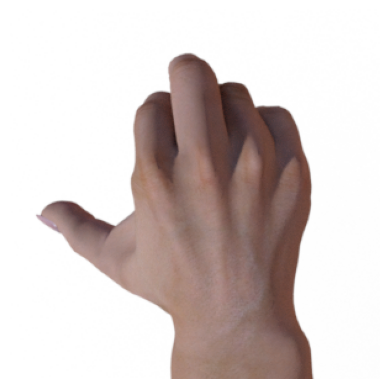

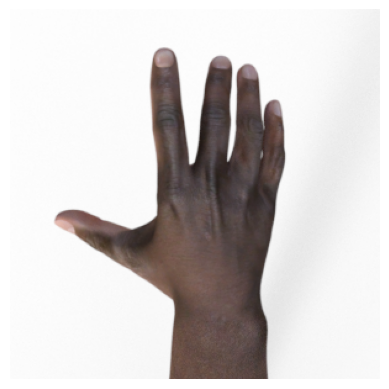

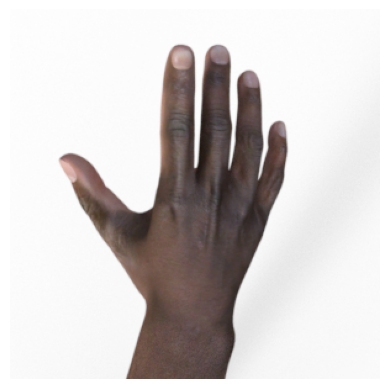

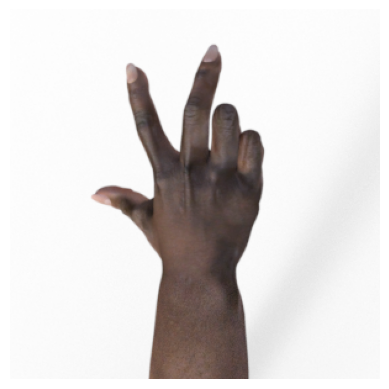

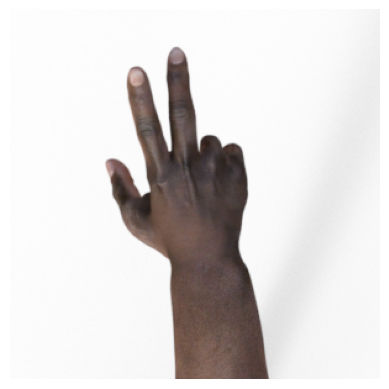

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

## Build the model

You will then build your CNN. You will use 4 convolution layers with 64-64-128-128 filters then append a `Dropout` layer to avoid overfitting and some Dense layers for the classification. The output layer would be a 3-neuron dense layer activated by [Softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax). You've seen this in Course 1 when you were training with Fashion MNIST. It scales your output to a set of probabilities that add up to 1. The order of this 3-neuron output would be `paper`-`rock`-`scissors` (e.g. a `[0.8 0.2 0.0]` output means the model is prediciting 80% probability for paper and 20% probability for rock.

You can examine the architecture with `model.summary()` below.

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

2024-04-30 19:57:32.806436: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 19:57:32.860063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 19:57:32.860082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 19:57:32.861473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 19:57:32.873779: I tensorflow/core/platform/cpu_feature_guar

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

You will then compile the model. The key change here is the `loss` function. Whereas before you were using `binary_crossentropy` for 2 classes, you will change it to [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-function) to extend it to more classes.

In [6]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Prepare the ImageDataGenerator

You will prepare the generators as before. You will set the training set up for data augmentation so it can mimick other poses that the model needs to learn.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "tmp/rps-train/rps"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test/rps-test-set"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## Train the model and evaluate the results

You will train for 25 epochs and evaludate the results afterwards. Observe how both the training and validation accuracy are trending upwards. This is a good indication that the model is not overfitting to only your training set.



In [8]:
# Train the model
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

Epoch 1/25


2024-04-30 19:58:07.483175: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-30 19:58:07.749523: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-30 19:58:08.772038: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-30 19:58:09.920776: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f869fed2db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-30 19:58:09.920808: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-04-30 19:58:09.938400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714499890.018125   42970 device_

20/20 [==============================] - 17s 533ms/step - loss: 1.1419 - accuracy: 0.3460 - val_loss: 1.0938 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 10s 511ms/step - loss: 1.1009 - accuracy: 0.3821 - val_loss: 1.0949 - val_accuracy: 0.3333
Epoch 3/25
20/20 [==============================] - 10s 507ms/step - loss: 1.0765 - accuracy: 0.4167 - val_loss: 1.0928 - val_accuracy: 0.3333
Epoch 4/25
20/20 [==============================] - 10s 474ms/step - loss: 1.0443 - accuracy: 0.4798 - val_loss: 0.8798 - val_accuracy: 0.7392
Epoch 5/25
20/20 [==============================] - 10s 475ms/step - loss: 0.9187 - accuracy: 0.5679 - val_loss: 0.7163 - val_accuracy: 0.6344
Epoch 6/25
20/20 [==============================] - 10s 473ms/step - loss: 0.7635 - accuracy: 0.6369 - val_loss: 0.3553 - val_accuracy: 0.9677
Epoch 7/25
20/20 [==============================] - 10s 491ms/step - loss: 0.7133 - accuracy: 0.6643 - val_loss: 0.3868 - val_accuracy: 0.9005
Epoch 8/25

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Model Prediction

You should be able to upload an image here and have it classified without crashing. This code block will only work in Google Colab, however. You can use your own images or use the ones available [here](https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-validation.zip)

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

In [ ]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

If you're using Safari and the cell above throws an error, you will need to upload the images(s) manually in their workspace.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [ ]:
# # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

# import os
# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#     print()
#     # predicting images
#     path = '/tmp/images/' + i
#     img = load_img(path, target_size=(150, 150))
#     x = img_to_array(img)
#     x = np.expand_dims(x, axis=0)
    
#     images = np.vstack([x])
#     classes = model.predict(images, batch_size=10)
#     print(path)
#     print(classes)

## Wrap Up

That concludes this short exercise on the multi-class classifiers. You saw that with just a few changes, you were able to convert your binary classifiers to predict more classes. You used the same techniques for data and model preparation and were able to get relatively good results in just 25 epochs. For practice, you can search for other datasets (e.g. [here](https://archive.ics.uci.edu/datasets)) with more classes and revise the model to accomodate it. Try to experiment with different layers and data augmentation techniques to improve your metrics.